<a href="https://colab.research.google.com/github/Eric-Oliveira-ds/leishticIA/blob/dev/AlexNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use pre-trained AlexNet to train and classifier leishmanioses and pyoderma images

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageOps
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Utils

In [3]:
# Definir as transformações personalizadas
class RandomBrightnessContrast:
    def __init__(self, brightness=(0.9, 1.1), contrast=(0.9, 1.1)):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, img):
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(*self.brightness))
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(*self.contrast))
        return img

class RandomCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        if random.random() > 0.5:
            img = ImageOps.equalize(img)
        return img

In [39]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradient = None

        # Encontrar a última camada convolucional
        # Supondo que você está usando AlexNet ou um modelo similar
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                self.target_layer = module

        # Registrar os hooks
        self.hook_handles = []
        self.hook_handles.append(
            self.target_layer.register_forward_hook(self.save_feature_maps)
        )
        self.hook_handles.append(
            self.target_layer.register_full_backward_hook(self.save_gradient)
        )

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        # Certifique-se de que o modelo está em modo de avaliação
        self.model.eval()

        # Forward pass
        model_output = self.model(input_image)

        if target_class is None:
            target_class = model_output.argmax(dim=1).item()

        # Zero all gradients
        self.model.zero_grad()

        # Backward pass with the target class
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1

        # Garanta que requires_grad está habilitado
        model_output.requires_grad_(True)
        model_output.backward(gradient=one_hot_output)

        # Verifique se temos os gradientes
        if self.gradient is None:
            raise ValueError("Gradients are None. Check if backward hook is working properly.")

        # Calculate weights for each channel
        pooled_gradients = torch.mean(self.gradient, dim=[2, 3])

        # Weight the channels by corresponding gradients
        cam = torch.zeros_like(self.feature_maps[0])
        for i in range(pooled_gradients.shape[1]):
            cam += pooled_gradients[0, i] * self.feature_maps[0, i]

        # Generate heatmap
        cam = torch.relu(cam)  # ReLU on the heatmap
        cam = cam.detach().cpu().numpy()

        # Normalize heatmap
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-7)  # Adicionado epsilon para evitar divisão por zero

        return cam

    def __del__(self):
        # Limpar os hooks quando o objeto for destruído
        for handle in self.hook_handles:
            handle.remove()

def visualize_gradcam(image_path, model, device, transform, class_names):
    # Load and preprocess image
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Create GradCAM instance
    grad_cam = GradCAM(model)

    try:
        # Generate heatmap
        heatmap = grad_cam.generate_cam(input_tensor)

        # Get model prediction
        with torch.no_grad():
            output = model(input_tensor)
            prediction = output.argmax(dim=1).item()
            confidence = F.softmax(output, dim=1)[0][prediction].item()

        # Convert heatmap to RGB
        heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Superimpose heatmap on original image
        img_array = np.array(img)
        superimposed = cv2.addWeighted(img_array, 0.6, heatmap, 0.4, 0)

        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.imshow(img)
        ax1.set_title('Original Image')
        ax1.axis('off')

        ax2.imshow(superimposed)
        ax2.set_title(f'GradCAM\nPrediction: {class_names[prediction]} ({confidence:.2%})')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        return prediction, confidence

    finally:
        # Limpar a memória
        grad_cam.__del__()

## Data Transformation

In [5]:
# Função para desnormalizar as imagens e converter para formato exibível
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Converte para formato HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormaliza
    img = np.clip(img, 0, 1)  # Limita os valores entre 0 e 1 para exibição
    plt.imshow(img)

In [6]:
# Definir as transformações para o dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomBrightnessContrast(),
        RandomCLAHE(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Carregar os datasets de treino e teste
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/train/', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/test/', transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualize transformations

In [8]:
# Obter um lote de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

Imagem 0, Label: 2
Imagem 1, Label: 0
Imagem 2, Label: 0
Imagem 3, Label: 0
Imagem 4, Label: 0
Imagem 5, Label: 2
Imagem 6, Label: 2
Imagem 7, Label: 2


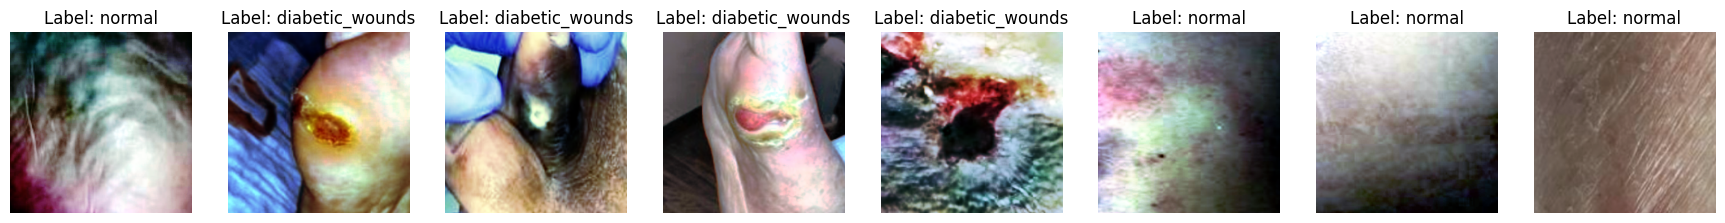

In [9]:
# Exibir as imagens com transformações
fig, axes = plt.subplots(1, len(images), figsize=(22, 10))
for i, img in enumerate(images):
    label_value = labels[i].item()
    print(f'Imagem {i}, Label: {label_value}')  # Mostra o valor do rótulo

    # Definir o rótulo baseado no valor
    if label_value == 0:
        label_text = 'diabetic_wounds'
    elif label_value == 1:
        label_text = 'leishmaniose'
    elif label_value == 2:
        label_text = 'normal'
    elif label_value == 3:
        label_text = 'pyoderma'
    elif label_value == 4:
        label_text = 'venous'
    else:
        label_text = 'unknown'

    ax = axes[i]
    ax.set_title(f"Label: {label_text}")
    ax.axis('off')
    plt.sca(ax)
    imshow(img)

plt.show()

In [10]:
train_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [11]:
test_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [12]:
print('length of train dataset: {}'.format(len(train_loader.dataset.samples)))

length of train dataset: 1261


In [13]:
print('length of test dataset: {}'.format(len(test_loader.dataset.samples)))

length of test dataset: 40


In [14]:
# Mapeamento de classes para índices
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


In [15]:
# Mapeamento de classes para índices
class_to_idx = test_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


## Model Train

In [16]:
# Carregar o modelo AlexNet pré-treinado
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

In [17]:
# Congelar os parâmetros do modelo para evitar treinar toda a rede
for param in model.parameters():
    param.requires_grad = False

In [18]:
# Modificar a última camada para se ajustar ao número de classes do seu dataset
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [19]:
num_classes

5

In [20]:
# Definir o otimizador e a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [21]:
# Treinamento do modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


In [24]:
!pip install torchsummary

In [25]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [26]:
!pip install torchviz

In [27]:
from torchviz import make_dot

In [28]:
sample_input = torch.randn(1, 3, 224, 224).to(device)  # Exemplo de entrada
y = model(sample_input)  # Passando o input pelo modelo
make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")

'model_architecture.png'

Epoch [1/50], Loss: 0.4176
Epoch [2/50], Loss: 0.2543
Epoch [3/50], Loss: 0.2091
Epoch [4/50], Loss: 0.2042
Epoch [5/50], Loss: 0.1707
Epoch [6/50], Loss: 0.1707
Epoch [7/50], Loss: 0.1158
Epoch [8/50], Loss: 0.1649
Epoch [9/50], Loss: 0.1283
Epoch [10/50], Loss: 0.1244
Epoch [11/50], Loss: 0.1328
Epoch [12/50], Loss: 0.1198
Epoch [13/50], Loss: 0.1172
Epoch [14/50], Loss: 0.1084
Epoch [15/50], Loss: 0.0967
Epoch [16/50], Loss: 0.1452
Epoch [17/50], Loss: 0.1169
Epoch [18/50], Loss: 0.0771
Epoch [19/50], Loss: 0.0880
Epoch [20/50], Loss: 0.0932
Epoch [21/50], Loss: 0.1152
Epoch [22/50], Loss: 0.0774
Epoch [23/50], Loss: 0.0932
Epoch [24/50], Loss: 0.0875
Epoch [25/50], Loss: 0.1060
Epoch [26/50], Loss: 0.0977
Epoch [27/50], Loss: 0.1002
Epoch [28/50], Loss: 0.1002
Epoch [29/50], Loss: 0.1154
Epoch [30/50], Loss: 0.1134
Epoch [31/50], Loss: 0.1243
Epoch [32/50], Loss: 0.1160
Epoch [33/50], Loss: 0.0785
Epoch [34/50], Loss: 0.0874
Epoch [35/50], Loss: 0.1121
Epoch [36/50], Loss: 0.1530
E

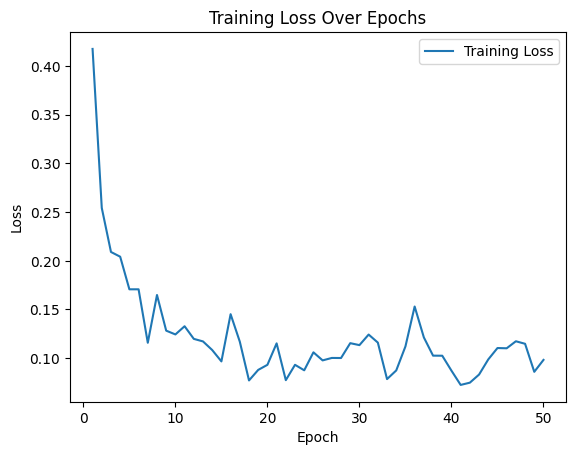

In [29]:
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Model Evatualion

In [30]:
# Avaliação do modelo
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # Armazene os rótulos e as previsões
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [31]:
print(f'Acurácia no conjunto de teste: {100 * correct / total:.2f}%')

Acurácia no conjunto de teste: 77.50%


In [32]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.71      0.62      0.67         8
           2       1.00      1.00      1.00         8
           3       0.60      0.38      0.46         8
           4       0.70      0.88      0.78         8

    accuracy                           0.78        40
   macro avg       0.76      0.78      0.76        40
weighted avg       0.76      0.78      0.76        40



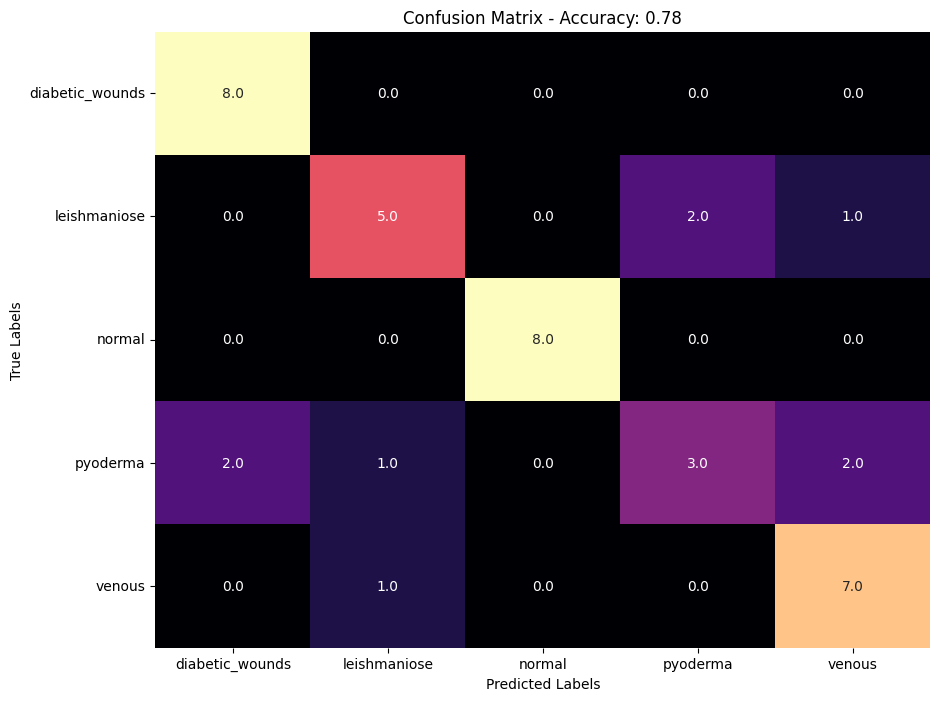

In [34]:
# Criar a matriz de confusão
cm = confusion_matrix(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

# Plotar a matriz de confusão com Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='.1f', cmap='magma', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}')
ax.set_xticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'])
ax.set_yticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'], rotation=0)
plt.show()

# Explainable AI

In [40]:
# Carregue uma imagem para teste
image_paths = ['/content/drive/MyDrive/dataset_classifier/test/diabetic_wounds/13_0.jpg',
              '/content/drive/MyDrive/dataset_classifier/test/leishmaniose/Imagem do WhatsApp de 2024-10-26 à(s) 20.39.03_041c824e.jpg',
              '/content/drive/MyDrive/dataset_classifier/test/normal/0711.jpg',
              '/content/drive/MyDrive/dataset_classifier/test/pyoderma/Imagem do WhatsApp de 2024-10-27 à(s) 17.12.33_ea46fe56.jpg',
              '/content/drive/MyDrive/dataset_classifier/test/venous/1558.jpg']
model.eval()  # Coloque o modelo em modo de avaliação

# Use as classes do seu dataset
class_names = ['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

# Visualize o GradCAM
for i, image_path in enumerate(image_paths):
    print(f'Image {i+1}')
    prediction, confidence = visualize_gradcam(
    image_path=image_path,
    model=model,
    device=device,
    transform=data_transforms['test'],  # Use a transformação de teste
    class_names=class_names)

Image 1


ValueError: Gradients are None. Check if backward hook is working properly.

## Model Deployment

In [ ]:
# Salvar o modelo após o treinamento
torch.save(model.state_dict(), 'alexnet_acc81_weights.pth')